### Import data

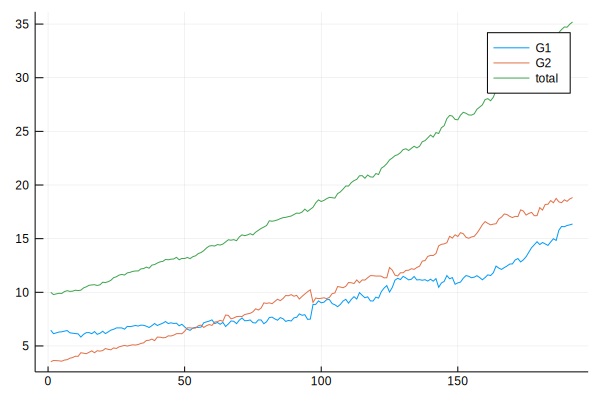

In [1]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq, DiffEqBase, Optim, Plots, Statistics
data = CSV.read(".//data//DOX.csv")
total = CSV.read(".//data//DOX_pop.csv")

total_old = total[1:192,4];
G2_old = data[1:192,4];

# rescaling the experimental data
total_new = 10.0 * total_old
G2_new = 0.01*total_new.*G2_old;
G1_new = total_new .- G2_new;
g1_0 = 10.0*(G2_old[1]/100.0)
g2_0 = 10.0*(1- (G2_old[1]/100.0))

plot(G1_new, label = "G1")
plot!(G2_new, label = "G2")
plot!(total_new, label = "total")


### ODE solve

In [ ]:
function ODEmodel(du, u, p, t)

    du[1] = -p[1]*u[1] + 2*p[2]*u[2] - p[3]*u[1]
    du[2] = p[1]*u[1] - p[2]*u[2] - p[4]*u[2]
end

function ODEsolve(par)
    t = LinRange(0.0, 95.5, 192)
    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = ODEProblem(ODEmodel, u0, tspan, par)
    solve(prob, Tsit5())
end

function residuals(par)
    t = LinRange(0.0, 95.5, 192)
    sol = ODEsolve(par)
    sol(t, idxs = 2).u - G2_new
end

p = [1.5, 2.5, 0.5, 3.0]
t = LinRange(0.0, 95.5, 192)
low = [0.0, 0.0, 0.0, 0.0]


result_ode = optimize(residuals, p, Dogleg(), lower = low)

In [ ]:
params = result_ode.minimizer
total_n = 5.0 .* total_old
G2_n = 0.01*total_n.*G2_old
G1_n = total_n - G2_n

sol = ODEsolve(params)
t = LinRange(0.0, 95.5, 192)

plot(t, sol(t, idxs=1).u, label = "G1 est")
plot!(t, G1_n, label = "G1")
plot!(t, sol(t, idxs=2).u, label = "G2 est", title = "Gem. Trial 9 ODE fit", legend=:topright)
plot!(t, G2_n, label = "G2")
plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
plot!(t, total_n, label = "total")
# savefig("dox_7_ode_24cut.png")

### Using Dogleg() for optimization DDE

In [17]:
# This model doesn't assume delay for dying
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[6]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[7]*u[2]
end

function DDEsolve(pp)
    lags = [pp[3], pp[4]]
    h(p, t) = pp[5]*ones(2)
    t = LinRange(0.0, 95.5, 192)
    
    tspan = (0.0, 95.5)
    u0 = [g1_0, g2_0]
    prob = DDEProblem(DDEmodel, u0, h, tspan, pp; constant_lags = lags)
    solve(prob, MethodOfSteps(Tsit5()))
end

function resid(pp)
    t = LinRange(0.0, 95.5, 192)
    res = zeros(2, length(t))
    sol = DDEsolve(pp)
    res[1, :] = sol(t, idxs=1) - G1_new
    res[2, :] = sol(t, idxs=2) - G2_new
#     sol(t, idxs=2) - G1_new
    return res
end

p = [0.081, 0.081, 0.15, 0.15, 10.0, 0.02, 0.02]
lowwer = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
upp = [1.0, 1.0, 10.0, 10.0, 5.0, 2.0, 2.0]
results = optimize(resid, p, Dogleg(), lower = lowwer)

Results of Optimization Algorithm
 * Algorithm: Dogleg
 * Minimizer: [0.08100000000000002,0.08099999999999999,0.15,0.15,10.0,0.01999999999999999,0.020000000000000004]
 * Sum of squares at Minimum: 4245.334698
 * Iterations: 26
 * Convergence: true
 * |x - x'| < 1.0e-08: true
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: false
 * |g(x)| < 1.0e-08: false
 * Function Calls: 27
 * Gradient Calls: 1
 * Multiplication Calls: 29


### Solve and Plot for Dogleg() optimization

In [21]:
params = results.minimizer

sol = DDEsolve(params)
t = LinRange(0.0, 95.5, 192)

plot(t, sol(t, idxs=2).u, label = "G1 est", legend =:topleft)
plot!(t, G1_new, label = "G1")
plot!(t, sol(t, idxs=1).u, title = "DOX Trial 4 DDE", label = "G2 est")
plot!(t, G2_new, label = "G2")
plot!(t, (sol(t, idxs=2).u + sol(t, idxs=1).u), label = "total est")
plot!(t, total_new, label = "total")
savefig("DOX_4_DDE.png")

### Optimization using Simulated Annealing

In [ ]:
import CSV
using LeastSquaresOptim, DifferentialEquations, DelayDiffEq
using DiffEqBase, Optim, LinearAlgebra, Plots
data = CSV.read(".//data//taxol1.csv")
total = CSV.read(".//data//taxol1_pop.csv")
total_old = total[48:end,9];
G2_old = data[48:end,9];

In [ ]:
estim_init = [1.8, 1.6] # [init_g1, init_g2]
# rescaling the experimental data
total_new = (estim_init[1] + estim_init[2]) * total_old
G2_new = 0.01*total_new.*G2_old
G1_new = total_new - G2_new
 
# This model doesn't assume delay for dying
function G1_G2(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[5])[1]) + 2*p[2]*(h(p, t-p[6])[2]) - p[3]*u[1]
    du[2] = p[1]*(h(p, t-p[5])[1]) - p[2]*(h(p, t-p[6])[2]) - p[4]*u[2] 
end

function solution(pp)
    lags = [pp[5], pp[6]]
    h(p, t) = pp[9]*ones(2)
    t = LinRange(0.0, 71.5, 145)
    tspan = (0.0, 71.5)
    u0 = [pp[7], pp[8]]

    prob = DDEProblem(G1_G2, u0, h, tspan, pp; constant_lags = lags)
    sol = solve(prob, MethodOfSteps(Tsit5()))
end

function resid(pp)
    t = LinRange(0.0, 71.5, 145)
    sol = solution(pp)
    res = sol(t, idxs=2) - G2_new
    
    return norm(res)
end

p = [8.31,1.38,0.78,0.70,7.55,7.76,1.8,1.6,4.65]
lowwer = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
upperr = [10.0, 10.0, 10.0, 10.0, 15.0, 15.0, 10.0, 10.0, 10.0]

res = optimize(resid, lowwer, upperr, p, SAMIN(rt = 0.7), Optim.Options(iterations = 10^5))


### Solve after SAMIN() optimization

In [ ]:
par = res.minimizer
total_nw = (par[7] + par[8]) * total_old
G2_new = 0.01*total_nw.*G2_old
G1_new = total_nw - G2_new
final = solution(par)
t = LinRange(0.0, 71.5, 145)

using Plots;
plot(t, final(t, idxs=2).u, label = "G2 est", title = "taxol Trial 10 samin(rt=0.7) 24cut")
plot!(t, G2_new, label = "G2")
plot!(t, (final(t, idxs=2).u + final(t, idxs=1).u), label = "total est")
plot!(t, total_nw, label = "total")
# plot!(t, final(t, idxs=1).u, label = "est G1")
savefig("taxol_one_10_samin_rt7_24cut.png")